In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

In [2]:
df = pd.read_csv('train.csv')
df.tail()

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
69708,APPU90955789628,Female,31/07/83,30/09/16,C10006,A,COM0000010,A,1.0,4900.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,10,0
69709,APPV80989824738,Female,27/01/71,30/09/16,C10116,C,COM0045789,A,4.0,7190.1,...,N,S122,G,1450.0,NaN,NaN,NaN,NaN,7,0
69710,APPW50697209842,Female,01/02/92,30/09/16,C10022,B,COM0013284,C,4.0,1600.0,...,Y,S122,G,0.0,24000.0,4.0,35.50,943.0,2,0
69711,APPY50870035036,Male,27/06/78,30/09/16,C10002,A,COM0000098,C,3.0,9893.0,...,Y,S122,G,1366.0,80000.0,5.0,NaN,NaN,10,0
69712,APPZ60733046119,Male,31/12/89,30/09/16,C10003,A,COM0000056,A,1.0,4230.0,...,Y,S122,G,0.0,69000.0,4.0,13.99,1885.0,10,0


In [3]:
# for checking the quality of clustering result
approve = df['Approved']

In [4]:
df.shape

(69713, 22)

In [5]:
df.isna().sum()

ID                                         0
Gender                                     0
DOB                                       15
Lead_Creation_Date                         0
City_Code                                814
City_Category                            814
Employer_Code                           4018
Employer_Category1                      4018
Employer_Category2                      4298
Monthly_Income                             0
Customer_Existing_Primary_Bank_Code     9391
Primary_Bank_Type                       9391
Contacted                                  0
Source                                     0
Source_Category                            0
Existing_EMI                              51
Loan_Amount                            27709
Loan_Period                            27709
Interest_Rate                          47437
EMI                                    47437
Var1                                       0
Approved                                   0
dtype: int

### Feature Engineering

In [6]:
# calculate age by the DOB column
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df['Age'] = (pd.Timestamp('now') - df['DOB']).astype('<m8[Y]').apply(lambda x:x+100 if x<0 else x)

In [7]:
df['EMI'] = df['EMI'].fillna(0)
df['Existing_EMI'] = df['Existing_EMI'].fillna(0)

df['Employer_Category2'] = df['Employer_Category2'].fillna('N/A')
df['Employer_Category1'] = df['Employer_Category1'].fillna('N/A')
df['City_Category'] = df['Employer_Category1'].fillna('N/A')

In [8]:
# features standardization

num_col = ['Age','Loan_Amount', 'Loan_Period','Monthly_Income','Interest_Rate','Age','EMI','Existing_EMI']

def standard_scaler(df,cols):
    for i in cols:
        df1 = pd.DataFrame(df[i])
        scaler = StandardScaler()
        df[i] = scaler.fit_transform(df1)

In [9]:
# replace na from selected columns with mean value

def remove_NaN(df,cols):
    for i in cols:
        df[i]=df[i].fillna(df[i].mean())

In [10]:
# call the above two functions to perform standardization and replace missing values

standard_scaler(df,num_col)
remove_NaN(df,num_col)

In [11]:
# checking the results of functions
df.isna().sum()

ID                                        0
Gender                                    0
DOB                                      15
Lead_Creation_Date                        0
City_Code                               814
City_Category                             0
Employer_Code                          4018
Employer_Category1                        0
Employer_Category2                        0
Monthly_Income                            0
Customer_Existing_Primary_Bank_Code    9391
Primary_Bank_Type                      9391
Contacted                                 0
Source                                    0
Source_Category                           0
Existing_EMI                              0
Loan_Amount                               0
Loan_Period                               0
Interest_Rate                             0
EMI                                       0
Var1                                      0
Approved                                  0
Age                             

In [12]:
# get a rough understang on statistical values of data and get rid of outliers
df.describe()

,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved,Age
count,6.971300e+04,6.971300e+04,6.971300e+04,6.971300e+04,6.971300e+04,6.971300e+04,69713.000000,69713.000000,6.971300e+04
mean,5.576320e-17,3.503806e-15,-7.911516e-16,4.672095e-15,-1.769377e-15,4.008250e-15,3.948446,0.014631,6.001890e-16
std,1.000007e+00,1.000007e+00,7.762320e-01,7.762320e-01,5.652816e-01,1.000007e+00,3.819214,0.120073,9.998996e-01
min,-3.217038e-02,-1.576549e-01,-1.120504e+00,-2.475963e+00,-1.235431e+00,-5.277265e-01,0.000000,0.000000,-1.993789e+00
25%,-2.272918e-02,-1.576549e-01,-3.068934e-01,7.534765e-15,-5.294148e-15,-5.277265e-01,0.000000,0.000000,-7.273602e-01
50%,-1.786553e-02,-1.576549e-01,-1.291614e-15,7.534765e-15,-5.294148e-15,-5.277265e-01,2.000000,0.000000,-1.645031e-01
75%,-9.282612e-03,-4.661790e-03,-1.291614e-15,9.368111e-02,-5.294148e-15,3.224269e-01,7.000000,0.000000,3.983540e-01
max,2.195980e+02,2.382652e+02,8.480101e+00,1.806777e+00,3.041973e+00,1.979799e+01,10.000000,1.000000,7.715496e+00


In [13]:
# remove outlier(in this case the max value) in monthly_income
df.drop(df.loc[df['Monthly_Income'] == df['Monthly_Income'].max()].index, inplace=True)


(69712, 23)


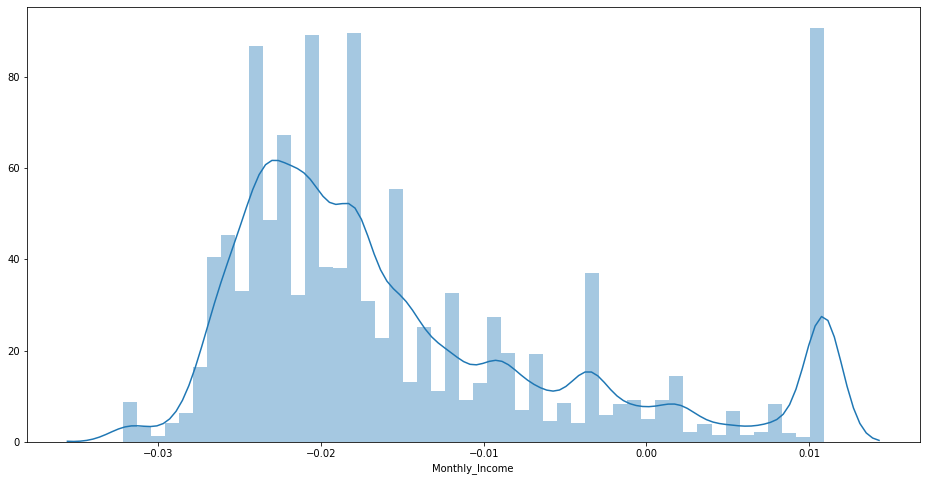

In [14]:
# dealing with outliers by utilizing inter-quartile with capping method

percentile25 = df['Monthly_Income'].quantile(0.25)
percentile75 = df['Monthly_Income'].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

#df[df['Monthly_Income'] > upper_limit]
#df[df['Monthly_Income'] < lower_limit]

#df = df[df['Monthly_Income'] < upper_limit]
#df.shape


# capping

df['Monthly_Income'] = np.where(
    df['Monthly_Income'] > upper_limit,
    upper_limit,
    np.where(
        df['Monthly_Income'] < lower_limit,
        lower_limit,
        df['Monthly_Income']
    )
)


# distribution polt to show how's the result of capping

plt.figure(figsize=(16,8))
sns.distplot(df['Monthly_Income'])

As we can see from the distribution plot, because of the capping method for outlier (above 0.75 quartile), we can observed that the last bar has a reletively high number.

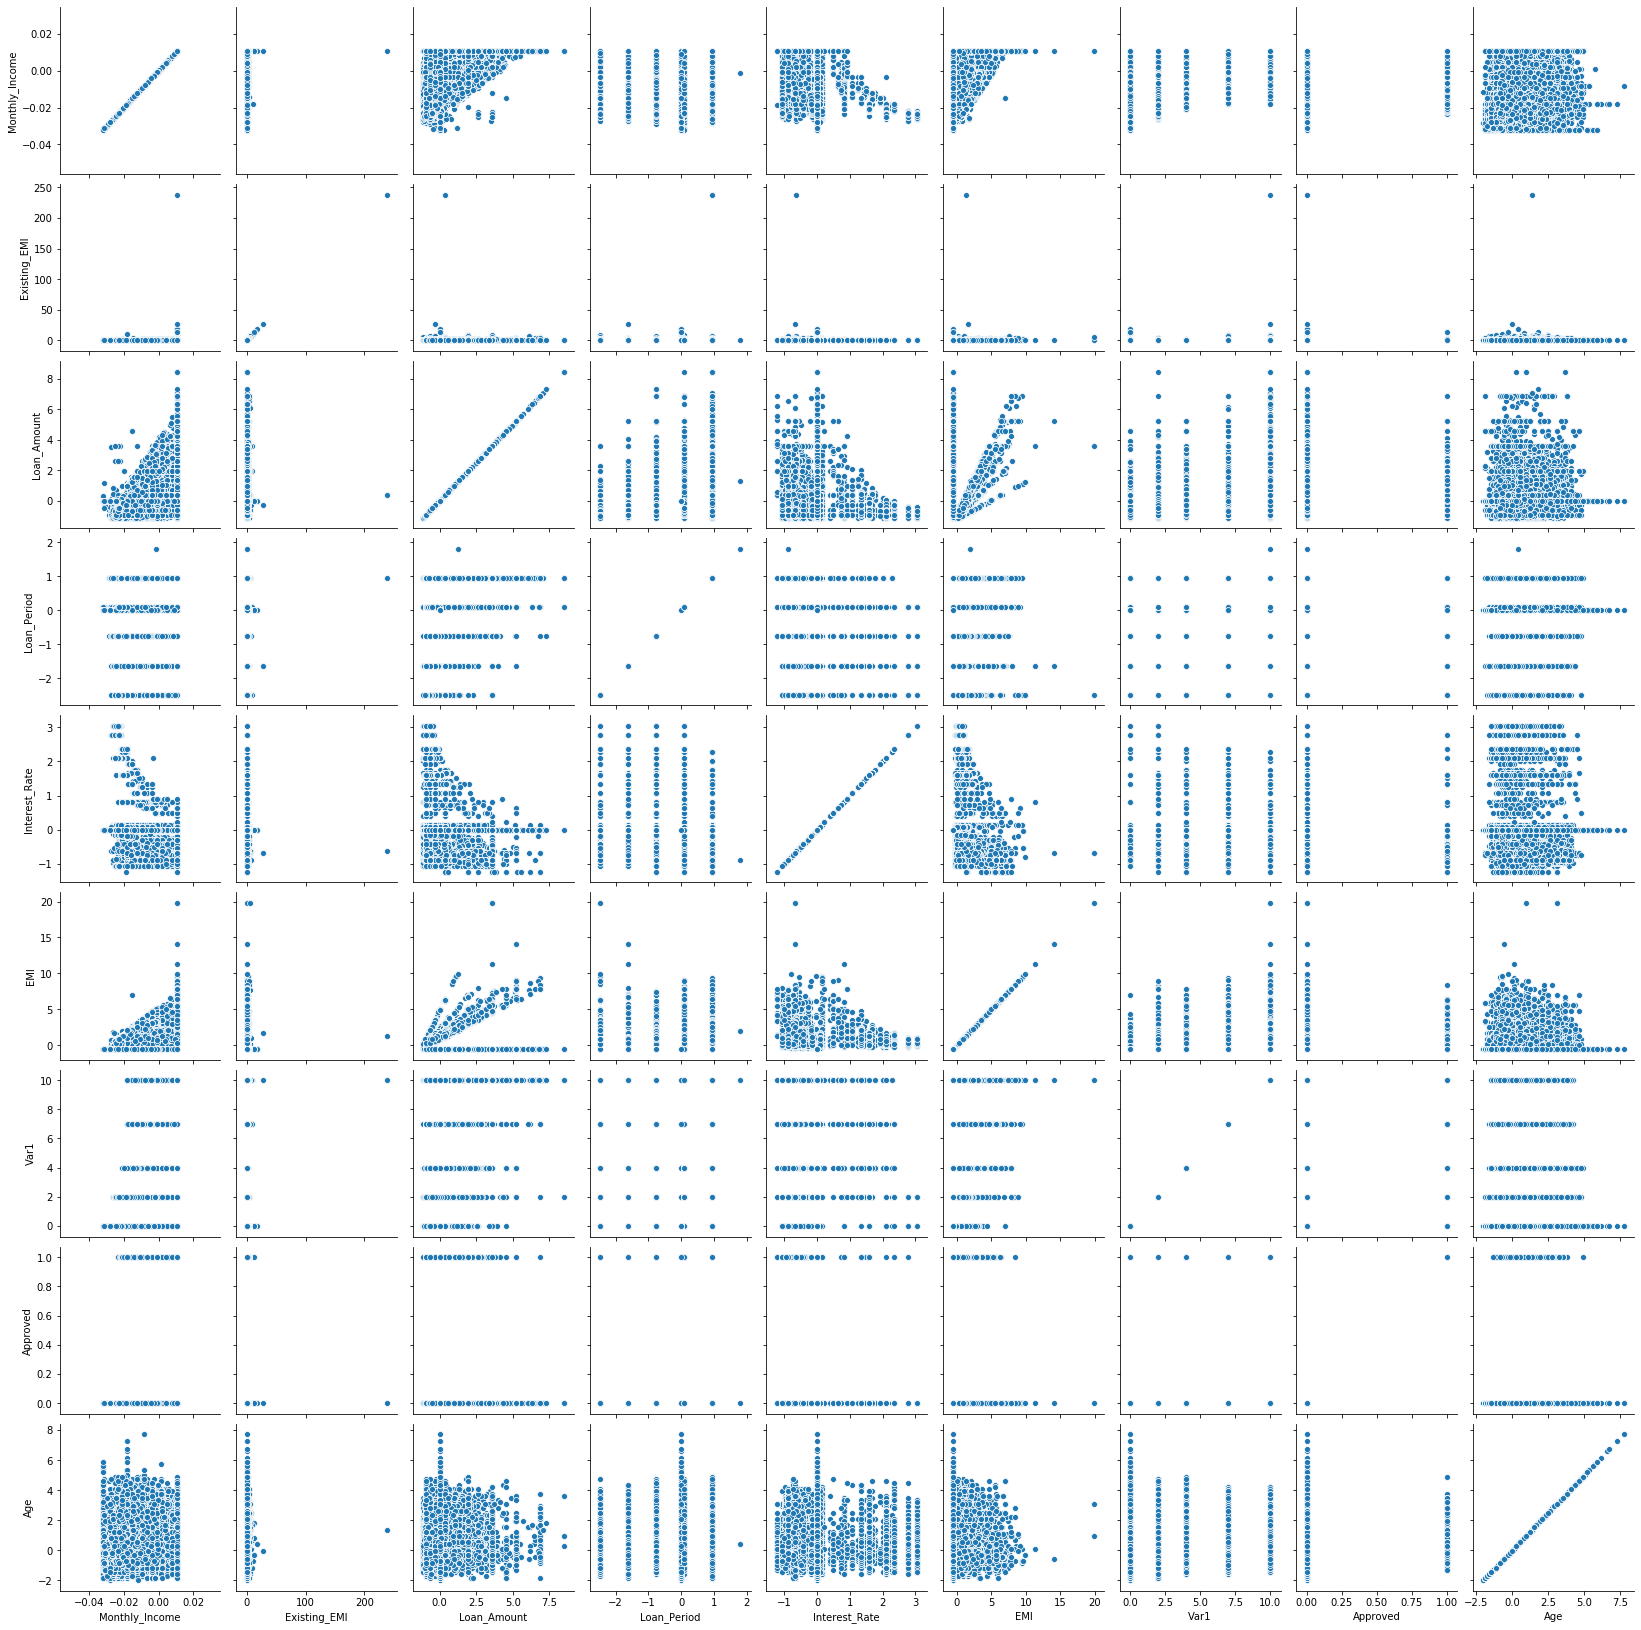

In [15]:
# visualize the correlation within the dataset and identify variables distribution for further analysis

cor_feature_plot = sns.PairGrid(df)
cor_feature_plot.map(sns.scatterplot)

As we can see from the pair plot, the are still some outliers in the subplots, but most of the columns with outliers won't be included in the model due to too many missing values.

In [16]:
# dropping unrelated features and features with too many missing values

drop_col = ['Approved','EMI','Existing_EMI','ID','Gender','DOB','Lead_Creation_Date','City_Code','Employer_Code','Customer_Existing_Primary_Bank_Code','Primary_Bank_Type']
df.drop(drop_col, axis=1,inplace=True)

In [17]:
# first need to check if there'a any missing value in the data before diving into one-hot encoding and building model
df.isnull().sum().sum()

0

In [18]:
# one-hot encoding

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res) 

feature_to_encode = ['Var1','City_Category','Employer_Category1','Employer_Category2','Contacted','Source_Category','Source']

for feature in feature_to_encode:
    df = encode_and_bind(df, feature)
    
# drop duplicate columns,after combining dummies columns and original column with numerical value 
df.drop(feature_to_encode, axis=1, inplace=True)   


In [19]:
df.shape

(69712, 56)

### PCA

The explained variance ratio is the percentage of variance that is attributed by each of the selected components. Ideally, you would choose the number of components to include in your model by adding the explained variance ratio of each component until you reach a total of around 0.8 or 80% to avoid overfitting.

In [20]:
# set 95% of variance

pca = PCA(n_components = 0.95)
pca.fit(df)
reduced = pca.transform(df)

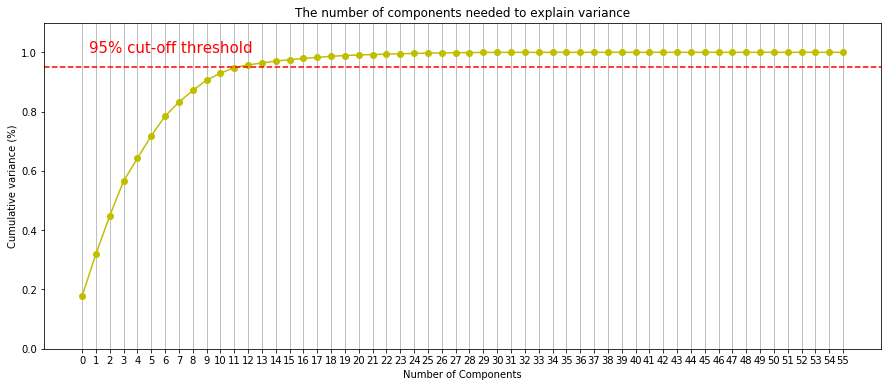

In [21]:
# select the optimal number of components

pca = PCA().fit(df)

plt.rcParams["figure.figsize"] = (15,6)

y = np.cumsum(pca.explained_variance_ratio_)
x = range(len(y))

plt.ylim(0.0,1.1)
plt.plot(x, y, marker='o', linestyle='-', color='y')

plt.xlabel('Number of Components')
plt.xticks(range(len(y))) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='red', linestyle='--')
plt.text(0.5, 1, '95% cut-off threshold', color = 'red', fontsize=15)

ax.grid(axis='x')
plt.show()

From the plot, we can observed that 11 components would yield 95% explained variance ratio. So later we would choose optimal number of clusters by using the results from PCA.

In [22]:
# calculate PCA scores with 9 components and output the percenge of explained variance

pca = PCA(11)
pca_fit = pca.fit_transform(df)

print ('Cumulative variance explained by 11 principal components: {:.2%}'\
       .format(np.sum(pca.explained_variance_ratio_)
                )
          )

Cumulative variance explained by 11 principal components: 92.97%


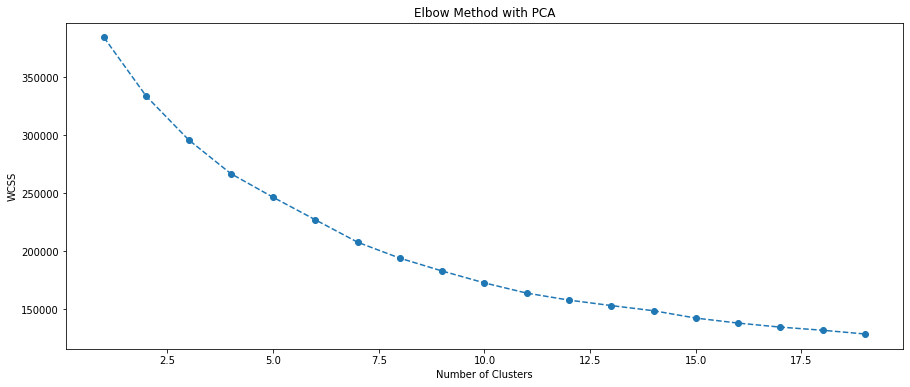

In [23]:
# Elbow method utilizing PCA result

wcss = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(pca_fit)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,20), wcss,marker='o',linestyle='--')
plt.title('Elbow Method with PCA')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

We can obsered a sharp decrease in sum of squares value around x= 4, thus this would be our choice for number of clusters would be use on K-means clustering forward. Though this plot didn't show a obviously sharp decrease on WCSS, it's still the best method to find out optimal number for k. 

### K-Means Clustering

In [24]:
# build KMeans model with PCA scores

kmeans_pca = KMeans(n_clusters=4,random_state=0,max_iter = 300,n_init = 10,init='k-means++')
y_kmeans = kmeans_pca.fit(pca_fit)

In [25]:
# based on the PCA score for each instance, the model would classified each instance to their most similar group

kmeans_labels = kmeans_pca.fit_predict(pca_fit)

pd.Series(kmeans_labels).value_counts()

1    27731
0    17251
3    16403
2     8327
dtype: int64

In [27]:
# add columns of distances to each component to original dataframe

df_cluster = pd.concat([df.reset_index(drop=True),pd.DataFrame(pca_fit)],axis=1) # reset_index to eliminate concatenating error due to index issue

In [29]:
# derive cluster number for each instance from KMeans model and store in a new column

df_cluster['cluster #'] = kmeans_pca.labels_

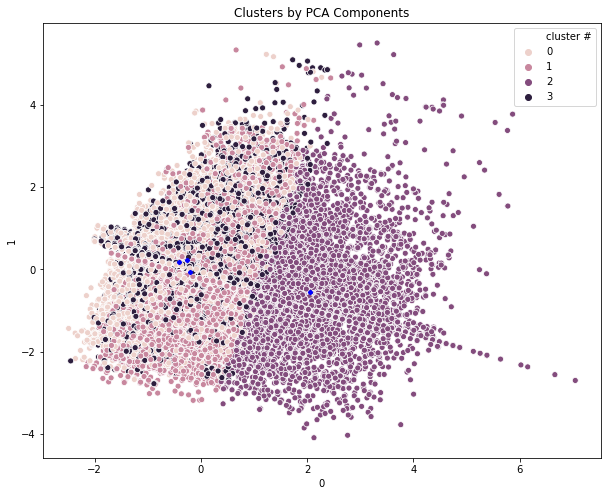

In [30]:
x_axis=df_cluster[0]
y_axis=df_cluster[1]
plt.figure(figsize=(10, 8))

sns.scatterplot(x_axis, y_axis, hue=df_cluster['cluster #'])

centers_pca= kmeans_pca.cluster_centers_

plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            marker='x', s=10, linewidths=4,
            color='b', zorder=10,lw=3)

plt.title('Clusters by PCA Components')
plt.show()

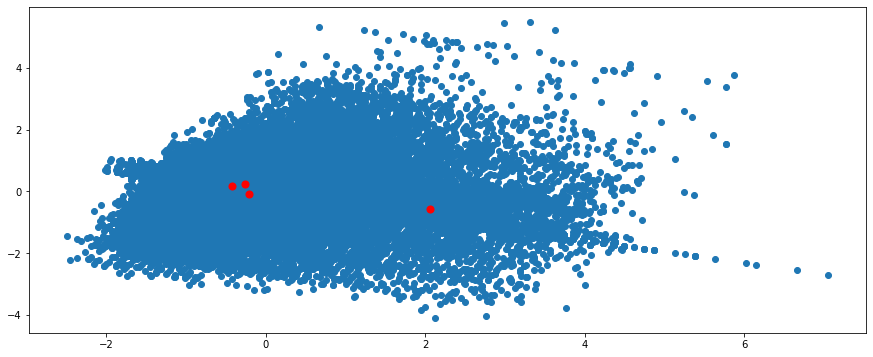

In [31]:
kmeans = KMeans(n_clusters = 4,                 
                init = 'k-means++',             
                max_iter = 300,                 
                n_init = 10,                   
                random_state = 0)               

pred_y = kmeans.fit_predict(pca_fit)


# Plot the data
plt.scatter(pca_fit[:,0], 
            pca_fit[:,1])

# Plot the clusters 
plt.scatter(kmeans_pca.cluster_centers_[:, 0], 
            kmeans_pca.cluster_centers_[:, 1], 
            s=50,                             
            c='red')                           
plt.show()

From the above K-means scatter plot, we can see that three of the clusters' centroids are really close to each other, while one cluster has enormous distance from the other. This might be indicated that k=4 might be a bit too many for the dataset, maybe two clusters would be beter. Or maybe need more data to better perform cluster analysis with the results of maximize inter-cluster distances and minimize intra-cluster distances.